In [44]:
import numpy as np
import os
from PIL import Image
from keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import seaborn as sns
import matplotlib.pyplot as plt
import random

In [2]:
# wczytanie danych
data_dir = 'data'
class_names = ['0', 'A', 'B', 'C']
img_sizes = set()

# określenie rozmiarów zdjęć
for class_name in class_names:
    class_dir = os.path.join(data_dir, class_name)
    for img_name in os.listdir(class_dir):
        if img_name.endswith('.jpg'):
            img_path = os.path.join(class_dir, img_name)
            with Image.open(img_path) as img:
                img_sizes.add(img.size)
                
if len(img_sizes) > 1:
    print("Obrazy w folderze 'data' nie są tego samego rozmiaru.")
else:
    img_size = img_sizes.pop()
    print(f"Rozmiar wszystkich obrazów w folderze 'data' wynosi {img_size}.")

# stworzenie etykiet na podstawie podfolderów

labels = []
data = []

for i, class_name in enumerate(class_names):
    class_dir = os.path.join(data_dir, class_name)

    for img_name in os.listdir(class_dir):
        if img_name.split('.')[1].lower() == 'jpg':
            img = load_img(os.path.join(class_dir, img_name), target_size=img_size)
            img_array = img_to_array(img)
            data.append(img_array)
            labels.append(i)



Rozmiar obrazów w folderze 'data' wynosi (300, 300).


In [3]:
# normalizacja danych
data = np.array(data) / 255.0
len(data)

1200

In [4]:
# augmentacja danych
train_datagen  = ImageDataGenerator(
    rotation_range=10,      # zakres kąta o który losowo zostanie wykonany obrót obrazów
   
    # width_shift_range=0.2,  # pionowe przekształcenia obrazu
    height_shift_range=0.1, # poziome przekształcenia obrazu
    # shear_range=0.2,        # zares losowego przycianania obrazu
    # zoom_range=0.2,         # zakres losowego przybliżania obrazu
    vertical_flip=True,   # losowe odbicie połowy obrazu w płaszczyźnie poziomej
    fill_mode='nearest'     # strategia wypełniania nowo utworzonych pikseli, któe mogą powstać w wyniku przekształceń
)

train_datagen.fit(data)


In [53]:
# podziałdanych w proporcji 8:1:1

# 80% na dane treningowe, 20% pozostaje do dalszego podziału
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.2, stratify=labels, random_state=42) 
# podział pozostałych danych na połowę, co daje po 10% na test i walidacje
val_data, test_data, val_labels, test_labels = train_test_split(test_data, test_labels, test_size=0.5, stratify=test_labels, random_state=42) 

In [49]:
# dostosowanie etykiet do formatu one-hot

train_labels = to_categorical(train_labels, num_classes=4)
val_labels = to_categorical(val_labels, num_classes=4)

In [7]:
# stworzenie generatora opartego na one-hot endoced etykietach
train_generator = train_datagen.flow(train_data, train_labels, batch_size=32,)


In [8]:
# własny model z przynajmniej dwiema wartwami splotowymi, z minimum jedną wartwą MaxPooling,
# z minimum jedną wartwą Dropout, z wartwom Flatten, oraz przynajmniej jedną warstwą Dense:


model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(300, 300, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(units=512, activation='relu'))
model.add(Dense(units=4, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 298, 298, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 149, 149, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 147, 147, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 73, 73, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 71, 71, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 35, 35, 128)      0

In [9]:
# zapis najlepszego modelu do pliku
checkpoint = ModelCheckpoint("best_model/best_model.h5", monitor='val_loss', verbose=1, save_best_only=True, mode='min')

In [10]:
# kompilacja modelu
model.compile(optimizer=RMSprop(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['acc'])

# wytrenowanie modelu
history = model.fit(
    train_generator,
    epochs=10,
    batch_size=32,
    validation_data=(val_data, val_labels),
    callbacks=[checkpoint]
)

Epoch 1/10
30/30 [==============================] - ETA: 0s - loss: 0.8435 - acc: 0.6792
Epoch 00001: val_loss improved from inf to 0.21289, saving model to best_model\best_model.h5
30/30 [==============================] - 150s 5s/step - loss: 0.8435 - acc: 0.6792 - val_loss: 0.2129 - val_acc: 0.9750
Epoch 2/10
30/30 [==============================] - ETA: 0s - loss: 0.2092 - acc: 0.9406
Epoch 00002: val_loss did not improve from 0.21289
30/30 [==============================] - 137s 5s/step - loss: 0.2092 - acc: 0.9406 - val_loss: 0.4388 - val_acc: 0.7750
Epoch 3/10
30/30 [==============================] - ETA: 0s - loss: 0.1340 - acc: 0.9531
Epoch 00003: val_loss improved from 0.21289 to 0.12136, saving model to best_model\best_model.h5
30/30 [==============================] - 143s 5s/step - loss: 0.1340 - acc: 0.9531 - val_loss: 0.1214 - val_acc: 0.9667
Epoch 4/10
30/30 [==============================] - ETA: 0s - loss: 0.1270 - acc: 0.9635
Epoch 00004: val_loss improved from 0.12136

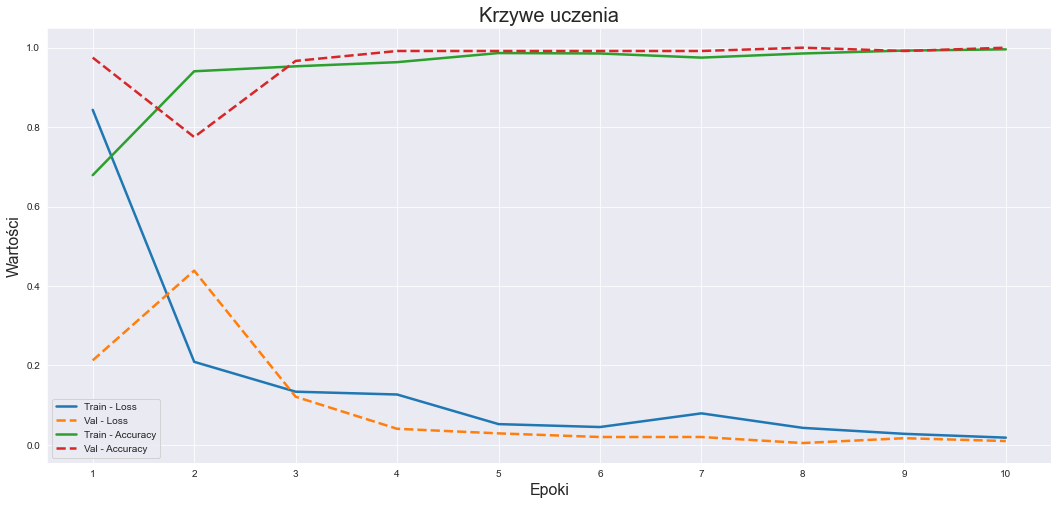

In [42]:
# wykres krzywych uczenia

# przypisanie wartości 'loss' i 'accuracy' dla treningu i walidacji
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['acc']
val_acc = history.history['val_acc']

sns.set_style('darkgrid')

# tworzenie wykresu
plt.figure(figsize=(18,8))
plt.plot(train_loss, label='Train - Loss', linewidth=2.5)
plt.plot(val_loss, label='Val - Loss', linestyle='--', linewidth=2.5)
plt.plot(train_acc, label='Train - Accuracy', linewidth=2.5)
plt.plot(val_acc, label='Val - Accuracy', linestyle='--', linewidth=2.5)

# zmiana etykiet na osi x na co 1
plt.xticks(range(len(train_loss)), range(1, len(train_loss)+1))

# dodanie opisów wykresu
plt.title('Krzywe uczenia', fontsize=20)
plt.xlabel('Epoki', fontsize=16)
plt.ylabel('Wartości', fontsize=16)
plt.legend()

plt.show()

In [57]:
# wyliczenie metryk na podstawie danych testowych

predictions = model.predict(test_data)
predicted_labels = np.argmax(predictions, axis=1)


accuracy = accuracy_score(test_labels, predicted_labels)
precision = precision_score(test_labels, predicted_labels, average='weighted')
recall = recall_score(test_labels, predicted_labels, average='weighted')
f1 = f1_score(test_labels, predicted_labels, average='weighted')


In [59]:
# wyświetlenie metryk

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")


Accuracy: 0.9917
Precision: 0.9919
Recall: 0.9917
F1-score: 0.9917


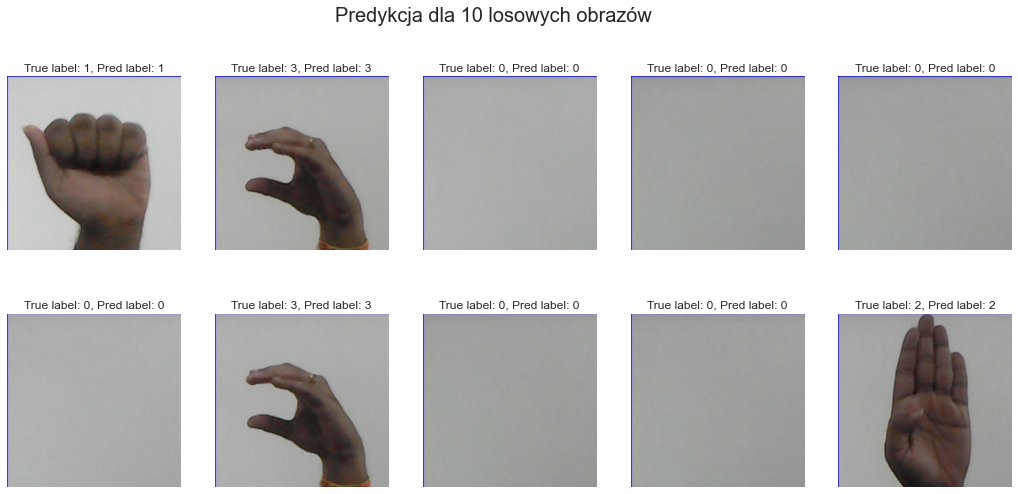

In [68]:
# wyświetlenie 10 losowych predykcji

# tworzenie subplota
fig, axs = plt.subplots(2, 5, figsize=(18, 8))
fig.subplots_adjust(hspace=.2)

# losowanie obrazów
indices = random.sample(range(len(test_data)), 10)

# wyśiwetlenie obrazkó wraz z opisami
for i, idx in enumerate(indices):
    ax = axs[i//5][i%5]
    ax.imshow(test_data[idx])
    true_label = test_labels[idx]
    pred_label = predicted_labels[idx]
    ax.set_title(f"True label: {true_label}, Pred label: {pred_label}")
    ax.axis('off')

fig.suptitle("Predykcja dla 10 losowych obrazów", fontsize=20)
plt.show()
